# Multiple input single output model


In [9]:
from src.loaders.data_loader import load_train_data
from src.loaders.window_generator import WindowGenerator
from src.preprocessors.preprocessors import split_train_valid_test
from src.preprocessors.preprocessors import apply_standard_scale
from src.model.multiple.dense import MultipleDense
from src.preprocessors.add_columns import add_sin_cos

df = load_train_data()
df = add_sin_cos(df, "Hour")
n = len(df)
train_df, valid_df, test_df = split_train_valid_test(df, [0.7, 0.2, 0.1])
scaled_train_df, scaled_valid_df, scaled_test_df = apply_standard_scale(train_df, valid_df, test_df)

ratio should be 3 length list, example: [0.6, 0.3, 0.1]
sum of ration should be 1, example: [0.7, 0.2, 0.1]
shape of train, valid, test: (36792, 11), (10511, 11), (5257, 11)


In [10]:
conv_window = WindowGenerator(
    train_df,
    valid_df,
    test_df,
    input_width=48,
    label_width=1,
    shift=1,
    label_columns=["TARGET"]
)
conv_window


            Total window size: 49
            Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47]
            Label indices: [48]
            Label column name(s): ['TARGET']
        

In [11]:
valid_performance = {}
performance = {}

In [12]:
from src.trainers import compile_and_fit_with_pinball_loss

multi_dense_model = MultipleDense()
history = compile_and_fit_with_pinball_loss(multi_dense_model, conv_window, 0.1)

valid_performance["Multi step dense"] = multi_dense_model.evaluate(conv_window.valid)
performance["Multi step dense"] = multi_dense_model.evaluate(conv_window.test, verbose=0)

Epoch 1/1000
1149/1149 [==============================] - 5s 4ms/step - loss: 3.2943 - mean_absolute_error: 23.0314 - mean_squared_error: 1616.3606 - _pinball_loss: 3.2943 - val_loss: 1.4330 - val_mean_absolute_error: 13.0729 - val_mean_squared_error: 447.9438 - val__pinball_loss: 1.4330

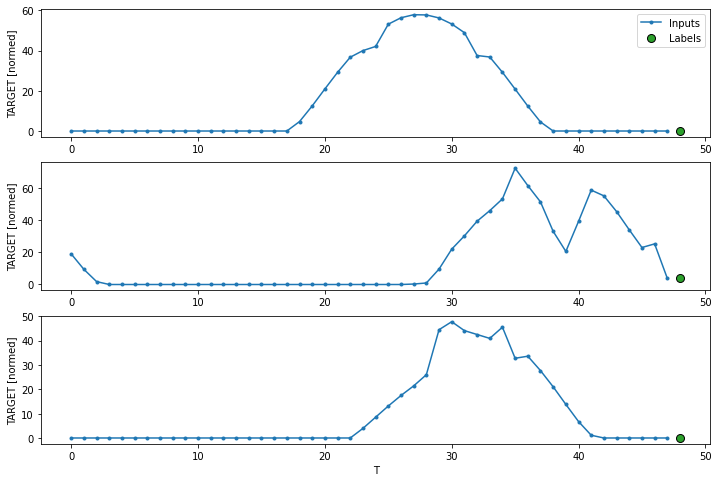

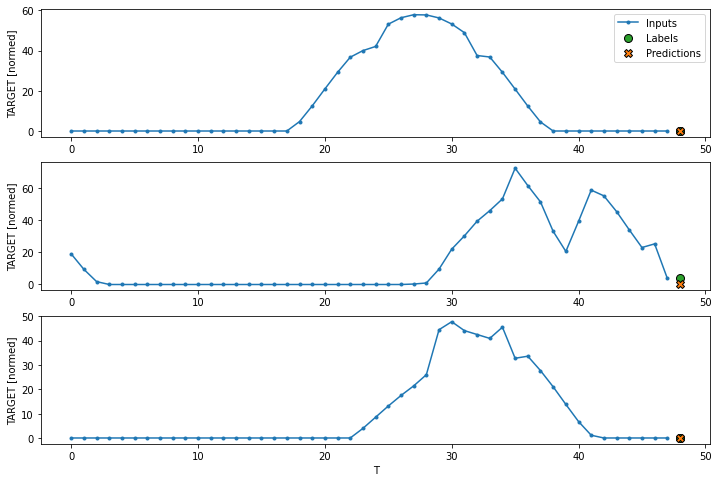

In [14]:
conv_window.plot()
conv_window.plot(multi_dense_model)

In [16]:
conv_window_scaled = WindowGenerator(
    scaled_train_df,
    scaled_valid_df,
    scaled_test_df,
    input_width=48,
    label_width=1,
    shift=1,
    label_columns=["TARGET"]
)
scaled_multi_dense_model = MultipleDense()
history = compile_and_fit_with_pinball_loss(scaled_multi_dense_model, conv_window_scaled, 0.1)



Epoch 1/1000
1149/1149 [==============================] - 5s 4ms/step - loss: 0.0684 - mean_absolute_error: 0.5144 - mean_squared_error: 0.5381 - _pinball_loss: 0.0684 - val_loss: 0.0520 - val_mean_absolute_error: 0.4091 - val_mean_squared_error: 0.4556 - val__pinball_loss: 0.0520

In [30]:
scaled_pred_y = scaled_multi_dense_model.predict(conv_window_scaled.test)


In [31]:
_mean = train_df["TARGET"].mean()
_std = train_df["TARGET"].std()
pred_y = (scaled_pred_y * _std + _mean).reshape(-1)

In [41]:
import numpy as np
true_y = test_df[48:]["TARGET"].values

np.mean(np.maximum(0.1 * (true_y - pred_y), (0.1 - 1) * (true_y - pred_y)))

6.546981700083197

In [42]:
np.maximum(0.1 * (true_y - pred_y), (0.1 - 1) * (true_y - pred_y))

array([3.45879123e+00, 3.27057301e+00, 1.76754255e+00, ...,
       5.90647316e-01, 4.37823612e+01, 2.57471085e-02])

In [43]:
pred_y = multi_dense_model.predict(conv_window.test)
np.mean(np.maximum(0.1 * (true_y - pred_y), (0.1 - 1) * (true_y - pred_y)))

7.564986091421568